# Optional Lab - Trees Ensemble

In this notebook, you will:

 - Use Pandas to perform one-hot encoding of a dataset
 - Use scikit-learn to implement a Decision Tree, Random Forest and XGBoost models

Let's import the libraries you will use.

In [45]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
'''
accuracy_score calculates the fraction of correct predictions, i.e.:
Accuracy = Number of correct predictions/Total number of predictions
'''
# !pip install xgboost --quiet
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

RANDOM_STATE = 55 ## You will pass it to every sklearn call so we ensure reproducibility

# 1. Loading the Dataset

From [Kaggle](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

Context
Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk need early detection and management wherein a machine learning model can be of great help.

You will develop models to predict how likely a particular person is in developing cardiovascular disease, given all the information below.

#### Attribute Information
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

Let's now load the dataset. As you can see above, the variables:

- Sex
- ChestPainType
- RestingECG
- ExerciseAngina
- ST_Slope

Are *categorical*, so you must one-hot encode them. 

In [46]:
# Load the dataset using pandas
df = pd.read_csv("heart.csv")

In [47]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [48]:
df.shape

(918, 12)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


You must perform some data engineering before working with the models. There are 5 categorical features, so you will use Pandas to one-hot encode them.

## 2. One-hot encoding using Pandas

First you will remove the binary variables, because one-hot encoding them would do nothing to them. To achieve this you will just count how many different values there are in each categorical variable and consider only the variables with 3 or more values.

In [50]:
cat_variables = ['Sex',
'ChestPainType',
'RestingECG',
'ExerciseAngina',
'ST_Slope'
]

As a reminder, one-hot encoding aims to transform a categorical variable with `n` outputs into `n` binary variables.

Pandas has a built-in method to one-hot encode variables, it is the function `pd.get_dummies`. There are several arguments to this function, but here you will use only a few. They are:

 - data: DataFrame to be used
 - prefix: A list with prefixes, so you know which value you are dealing with
 - columns: the list of columns that will be one-hot encoded. 'prefix' and 'columns' must have the same length.
 
For more information, you can always type `help(pd.get_dummies)` to read the function's full documentation.

In [51]:
# This will replace the columns with the one-hot encoded ones and keep the columns outside 'columns' argument as it is.
df = pd.get_dummies(data = df,                      # The original DataFrame
                         prefix = cat_variables,    # Prefix for new column name
                         columns = cat_variables)   # Which categorical columns to encode
# That line is using pandas.get_dummies() to turn categorical variables into one-hot encoded columns.
# The problem it solves:
# Machine learning models (like logistic regression, decision trees, neural networks) can’t directly understand text categories like "Red", "Blue", "Green".
# We need to turn them into numeric form — one-hot encoding does exactly that.

In [52]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,...,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True


In [53]:
df.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease', 'Sex_F', 'Sex_M', 'ChestPainType_ASY',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST',
       'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

In [54]:
d = df.columns
type(d)
len(d)

21

Let's choose the variables that will be the input features of the model.
- The target is `HeartDisease`.
- All other variables are features that can potentially be used to predict the target, `HeartDisease`.

In [55]:
features = [x for x in df.columns if x not in 'HeartDisease'] ## Removing our target variable
'''
for x in df.columns → loops over each column name.
if x not in 'HeartDisease' → keep x only if it’s not in the string "HeartDisease".
⚠ Important:
This is a bit tricky — 'HeartDisease' here is a string, not a list.
So x not in 'HeartDisease' means:

"Is the entire column name not equal to any character inside the word 'HeartDisease'?"
This is probably a bug — it’s checking characters, not full names.

Example:
'Age' not in 'HeartDisease'  # True (kept)
'Sex' not in 'HeartDisease'  # True (kept)
'HeartDisease' not in 'HeartDisease'  # False (removed)
The result is a list of column names, features, except the one that matches 'HeartDisease'.
'''
# ✅ Better (safer) version
# If you want to drop the "HeartDisease" column name, use:
features = [x for x in df.columns if x != 'HeartDisease']
# This way, it compares the whole column name, not characters inside it.

We started with 11 features.  Let's see how many feature variables we have after one-hot encoding.

In [56]:
print(len(features))

20


# 3. Splitting the Dataset

In this section, you will split our dataset into train and test datasets. You will use the function `train_test_split` from Scikit-learn. Let's just check its arguments.

In [57]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets.
    
    Quick utility that wraps input validation,
    ``next(ShuffleSplit().split(X, y))``, and application to input data
    into a single call for splitting (and optionally subsampling) data into a
    one-liner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to

In [58]:
df[features].head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,False,True,False,True,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,True,False,False,False,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,False,True,False,True,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,True,False,True,False,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,False,True,False,False,True,False,False,True,False,True,False,False,False,True


In [59]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   RestingBP          918 non-null    int64  
 2   Cholesterol        918 non-null    int64  
 3   FastingBS          918 non-null    int64  
 4   MaxHR              918 non-null    int64  
 5   Oldpeak            918 non-null    float64
 6   Sex_F              918 non-null    bool   
 7   Sex_M              918 non-null    bool   
 8   ChestPainType_ASY  918 non-null    bool   
 9   ChestPainType_ATA  918 non-null    bool   
 10  ChestPainType_NAP  918 non-null    bool   
 11  ChestPainType_TA   918 non-null    bool   
 12  RestingECG_LVH     918 non-null    bool   
 13  RestingECG_Normal  918 non-null    bool   
 14  RestingECG_ST      918 non-null    bool   
 15  ExerciseAngina_N   918 non-null    bool   
 16  ExerciseAngina_Y   918 non

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df[var], df['HeartDisease'], train_size = 0.8, random_state = RANDOM_STATE)
# We will keep the shuffle = True since our dataset has not any time dependency.

#train_test_split(): Randomly splits your data into training and testing subsets.

# Inputs
# df[var] → All feature columns (X)
# var is a list of column names except 'HeartDisease' (your target variable).
# These are your independent variables.
# df['HeartDisease'] → Target column (y)
# This is the label you want to predict.

# Parameters
# train_size = 0.8
# 80% of the data will be used for training.
# The remaining 20% will be used for testing.
# random_state = RANDOM_STATE
# Ensures reproducibility — you’ll get the same split every time you run the c

In [61]:
print(f'train samples: {len(X_train)}\ntest samples: {len(X_test)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')
print(f'target proportion: {sum(y_test)/len(y_test):.4f}')

train samples: 734
test samples: 184
target proportion: 0.5518
target proportion: 0.5598


# 4. Building the Models

## 4.1 Decision Tree
In this section, let's work with the Decision Tree we previously learned, but now using the [Scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 

There are several hyperparameters in the Decision Tree object from Scikit-learn. We will use only some of them and also we will not perform feature selection nor hyperparameter tuning in this lab (but you are encouraged to do so and compare the results 😄 )

The hyperparameters we will use and investigate here are:

 - min_samples_split: The minimum number of samples required to split an internal node. 
   - Choosing a higher min_samples_split can reduce the number of splits and may help to reduce overfitting.
 - max_depth: The maximum depth of the tree. 
   - Choosing a lower max_depth can reduce the number of splits and may help to reduce overfitting.

In [62]:
# lists of possible hyperparameter values that you’ll likely test when tuning a decision tree.
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,
'''
This is the min_samples_split hyperparameter.
Meaning: The minimum number of samples a node must have before it can be split into child nodes.

If you set it to:
2 → The smallest possible value in scikit-learn. A node will split if it has 2 or more samples.
10 → A node must have at least 10 samples to even consider splitting.
200 → Only large groups of samples will split, producing a smaller, simpler tree.
Larger values → fewer splits → simpler, less overfit model.
Smaller values → more splits → more complex, potentially overfit model.
'''
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.
'''
This is the max_depth hyperparameter.

Meaning: The maximum number of levels the tree can grow.

If you set it to:
1 → The tree will only have a root and leaves (very simple).
4 → The tree can only split 4 levels deep.
None → No restriction — the tree will grow until it perfectly fits the training data or hits another stopping condition.
Smaller values → higher bias, less overfitting.
Larger values → lower bias, more risk of overfitting.
'''




'''
In a decision tree, a hyperparameter is a setting you choose before training that controls how the tree is built — not something the model learns from the data.

Hyperparameters in Decision Trees
Some common ones are:

1) max_depth:
    Maximum number of levels the tree can grow.
    Controls how complex the tree can get.
    Large values → more complex model (risk of overfitting).
    Small values → simpler model (risk of underfitting).

2) min_samples_split:
    Minimum number of samples required to split a node.
    Larger values → fewer splits → simpler tree.

3) min_samples_leaf:
    Minimum number of samples required to be in a leaf node.

4) max_features
    How many features to consider when looking for the best split (important in random forests).

5) criterion
    Function used to measure the quality of a split.
        Classification: "gini" or "entropy".
        Regression: "mse" (mean squared error), "mae" (mean absolute error).

Why they matter
    They control the bias–variance tradeoff:
        More restrictive hyperparameters → higher bias, lower variance.
        More flexible hyperparameters → lower bias, higher variance.
    Choosing good hyperparameters is often done via hyperparameter tuning (e.g., grid search, random search, Bayesian optimization).

💡 In short:
In a decision tree, hyperparameters are knobs you set before training that determine how the tree grows and how complex it becomes. They’re not learned from the data, but they influence the model’s final performance.
''';

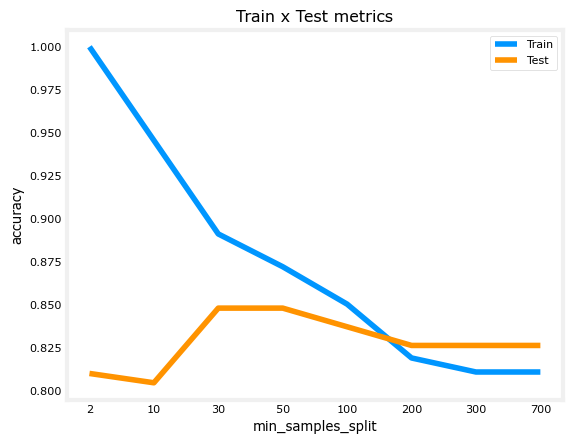

In [63]:
accuracy_list_train = []
accuracy_list_test = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
'''
min_samples_split_list is:      [2, 10, 30, 50, 100, 200, 300, 700]
range(len(min_samples_split_list))

len(min_samples_split_list) → 8
range(8) → [0, 1, 2, 3, 4, 5, 6, 7]
These numbers represent the positions where ticks will appear on the x-axis.

labels=min_samples_split_list
The displayed labels at those positions will be: [2, 10, 30, 50, 100, 200, 300, 700]
'''
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

Note how increasing the the number of `min_samples_split` reduces overfitting.
- Increasing `min_samples_split` from 10 to 30, and from 30 to 50, even though it does not improve the validation accuracy, it brings the training accuracy closer to it, showing a reduction in overfitting.

Let's do the same experiment with `max_depth`.

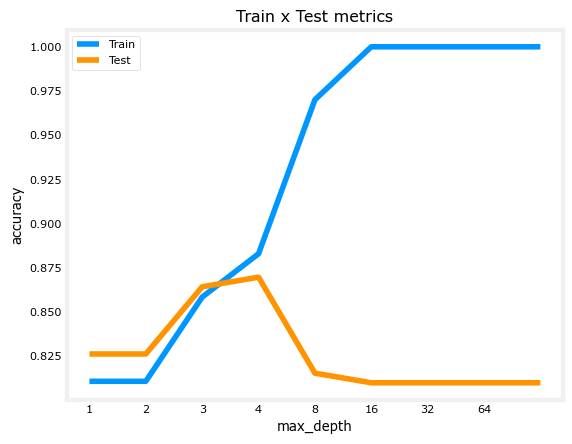

In [64]:
accuracy_list_train = []
accuracy_list_test = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

We can see that in general, reducing `max_depth` can help to reduce overfitting.
- Reducing `max_depth` from 8 to 4 increases validation accuracy closer to training accuracy, while significantly reducing training accuracy.
- The validation accuracy reaches the highest at tree_depth=4. 
- When the `max_depth` is smaller than 3, both training and validation accuracy decreases.  The tree cannot make enough splits to distinguish positives from negatives (the model is underfitting the training set). 
- When the `max_depth` is too high ( >= 5), validation accuracy decreases while training accuracy increases, indicating that the model is overfitting to the training set.

So we can choose the best values for these two hyper-parameters for our model to be:
- `max_depth = 4`
- `min_samples_split = 50` 

In [65]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 50,
                                             max_depth = 3,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

In [66]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.8583
Metrics test:
	Accuracy score: 0.8641


No sign of overfit, even though the metrics are not that good.

## 4.2 Random Forest

Now let's try the Random Forest algorithm also, using the Scikit-learn implementation. 
- All of the hyperparameters found in the decision tree model will also exist in this algorithm, since a random forest is an ensemble of many Decision Trees.
- One additional hyperparameter for Random Forest is called `n_estimators` which is the number of Decision Trees that make up the Random Forest. 

Remember that for a Random Forest, we randomly choose a subset of the features AND randomly choose a subset of the training examples to train each individual tree.
- Following the lectures, if $n$ is the number of features, we will randomly select $\sqrt{n}$ of these features to train each individual tree. 
- Note that you can modify this by setting the `max_features` parameter.

You can also speed up your training jobs with another parameter, `n_jobs`. 
- Since the fitting of each tree is independent of each other, it is possible fit more than one tree in parallel. 
- So setting `n_jobs` higher will increase how many CPU cores it will use. Note that the numbers very close to the maximum cores of your CPU may impact on the overall performance of your PC and even lead to freezes. 
- Changing this parameter does not impact on the final result but can reduce the training time.

We will run the same script again, but with another parameter, `n_estimators`, where we will choose between 10, 50, and 100. The default is 100.

<details>
  <summary><b style="color:red;">more information:RandomForestClassifier Hyperparameters in scikit-learn — Grouped by Purpose</b></summary> 

Below is a breakdown of the most important hyperparameters, **grouped by what they control**.


#### **1️⃣ Tree Structure Control**
These limit **how deep or complex** each tree can grow.

| Hyperparameter         | Meaning | Why it matters |
|------------------------|---------|----------------|
| `n_estimators` (default=100) | Number of decision trees in the forest. | More trees → better performance (up to a point), but slower. |
| `max_depth` (default=None)   | Maximum depth of each tree. `None` = grow until leaves are pure or contain `< min_samples_split` samples. | Smaller values prevent overfitting. |
| `min_samples_split` (default=2) | Minimum samples required to split a node. | Higher values make trees less complex. |
| `min_samples_leaf` (default=1)  | Minimum samples in a leaf node. | Prevents creating leaves with very few samples. |
| `max_leaf_nodes` (default=None) | Maximum number of leaf nodes per tree. | Limits complexity even if `max_depth=None`. |


#### **2️⃣ Feature Selection at Splits**
These control **feature randomness** to decorrelate trees.

| Hyperparameter         | Meaning | Why it matters |
|------------------------|---------|----------------|
| `max_features` (default="sqrt") | Number of features to consider for best split (`"sqrt"`, `"log2"`, int, or float). | Smaller → more randomness, less correlation, but possibly weaker trees. |
| `max_samples` (default=None)    | Number (or fraction) of samples used to train each tree. | Smaller → more randomness, faster training. |

#### **3️⃣ Randomness & Reproducibility**

| Hyperparameter         | Meaning |
|------------------------|---------|
| `bootstrap` (default=True) | Sample with replacement to create bootstrap samples for each tree. |
| `random_state`         | Controls reproducibility of results. |


#### **4️⃣ Computational Performance**

| Hyperparameter         | Meaning |
|------------------------|---------|
| `n_jobs` (default=None) | Number of CPU cores for parallel processing (`-1` = all cores). |
| `verbose`              | Controls output logging during training. |



#### **5️⃣ Class Imbalance Handling**

| Hyperparameter         | Meaning |
|------------------------|---------|
| `class_weight` (default=None) | Adjusts weights inversely proportional to class frequency — useful for imbalanced datasets. |


#### **🎯 Typical Tuning Strategy**

Most impactful parameters to tune:

- **`n_estimators`** → start with 200–500 for stability.  
- **`max_depth`** → prevents overfitting.  
- **`min_samples_split`** & **`min_samples_leaf`** → increase to regularize.  
- **`max_features`** → lowering can improve generalization.  
- **`class_weight`** → handle imbalance in classes.  


</details>

In [67]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

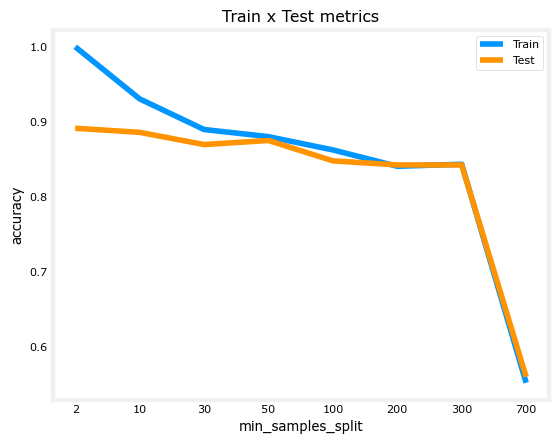

In [68]:
accuracy_list_train = []
accuracy_list_test = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

Notice that, even though the validation accuraty reaches is the same both at `min_samples_split = 2` and `min_samples_split = 10`, in the latter the difference in training and validation set reduces, showing less overfitting.

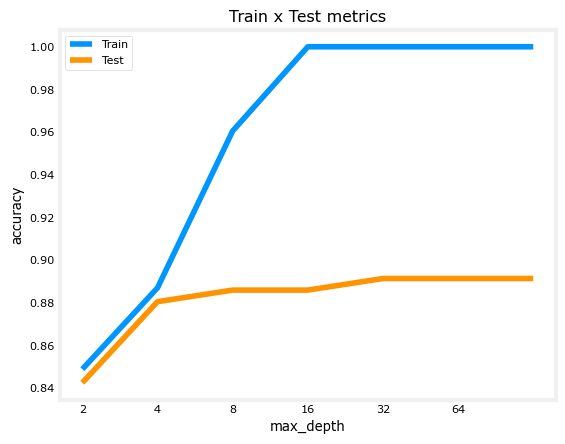

In [69]:
accuracy_list_train = []
accuracy_list_test = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

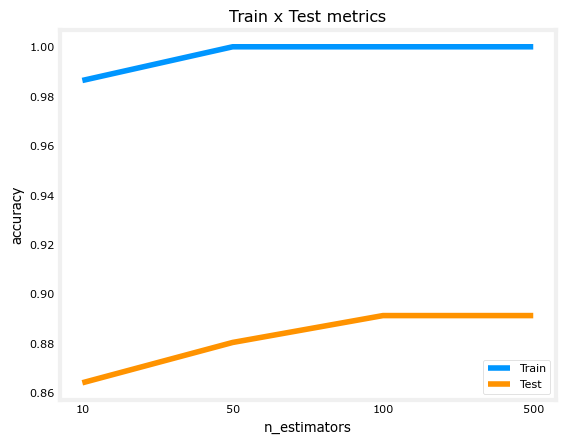

In [70]:
accuracy_list_train = []
accuracy_list_test = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

Let's then fit a random forest with the following parameters:

 - max_depth: 32
 - min_samples_split: 10
 - n_estimators: 100

In [ ]:
random_forest_model = RandomForestClassifier(n_estimators = 100,
                                             max_depth = 32, 
                                             min_samples_split = 10).fit(X_train,y_train)
'''
In RandomForestClassifier, the random feature selection happens at each split inside each decision tree, and it’s controlled by the hyperparameter max_features.

By default in scikit-learn:         
    Classification → max_features = "sqrt"
    Regression → max_features = 1.0 (all features)

So in your case:
Since you didn’t specify max_features, it defaults to "sqrt", meaning:
If you have p features, at each node split the algorithm randomly selects √p features and chooses the best split among them.
This happens independently in each tree and at each split, which is what makes it a random forest rather than just bagged decision trees.

If you want to see exactly where this randomness comes in:
Bagging step → Randomly sample training rows (with replacement) for each tree (bootstrap=True by default).
Feature subspace step → Randomly pick max_features features for each split.
'''

In [72]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.9360
Metrics test:
	Accuracy score: 0.8967


In [79]:
random_forest_model = RandomForestClassifier(n_estimators = 100,
                                             max_depth = 16, 
                                             min_samples_split = 10).fit(X_train,y_train)

In [80]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.9401
Metrics test:
	Accuracy score: 0.8967


Note that we are searching for the best value one hyperparameter while leaving the other hyperparameters at their default values.
- Ideally, we would want to check every combination of values for every hyperparameter that we are tuning.
- If we have 3 hyperparameters, and each hyperparameter has 4 values to try out, we should have a total of 4 x 4 x 4 = 64 combinations to try.
- When we only modify one hyperparameter while leaving the rest as their default value, we are trying 4 + 4 + 4 = 12 results. 
- To try out all combinations, we can use a sklearn implementation called GridSearchCV. GridSearchCV has a refit parameter that will automatically refit a model on the best combination so we will not need to program it explicitly. For more on GridSearchCV, please refer to its [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# GridSearchCV from sklearn.model_selection will try all combinations of your hyperparameter values, train the model on the training set, evaluate it using cross-validation, and then tell you which set performs best.

# 1. Define the parameter grid
param_grid = {
    'n_estimators': n_estimators_list,
    'max_depth': max_depth_list,
    'min_samples_split': min_samples_split_list
}

# 2. Create the model
rf = RandomForestClassifier()

# 3. Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,               # 5-fold cross-validation
    scoring='accuracy', # or 'f1', 'roc_auc', etc., depending on your goal
    n_jobs=-1,          # use all CPU cores
    verbose=2           # show progress
)

# 4. Fit the grid search
grid_search.fit(X_train, y_train)

# 5. Best hyperparameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# 6. Train final model with best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)


# How it works
# param_grid → lists all possible values you want to try.

# GridSearchCV will try every combination of these parameters
# (in your case: 4 × 7 × 8 = 224 combinations).

# For each combination, it will:
# Split your training data into cv folds (e.g., 5).
# Train on 4 folds, validate on 1 fold.
# Repeat for all folds and average the score.
# It selects the parameter combination with the highest average score.


# is 'fold' the same as 'group'?
# exactly! in cross-validation, a fold is basically just a group (or chunk) of your dataset.
# For example, in 5-fold cross-validation:
# You split your training set into 5 equal groups (folds).
# Then you train the model 5 times:
# Use folds 1–4 for training, fold 5 for validation
# Use folds 1–3 & 5 for training, fold 4 for validation
# And so on… until each fold has been the validation set once.
# Finally, you average the 5 validation scores → this gives a more reliable estimate of how the model will perform on unseen data.




Fitting 5 folds for each of 224 candidates, totalling 1120 fits
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END .max_depth=2, min_samples_split=2, n_estimators=500; total time=   0.4s
[CV] END .max_depth=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END .max_depth=2, min_samples_split=10, 

,n_estimators,100
,criterion,'gini'
,max_depth,16
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 4.3 XGBoost

Next is the Gradient Boosting model, called XGBoost. The boosting methods train several trees, but instead of them being uncorrelated to each other, now the trees are fit one after the other in order to minimize the error. 

The model has the same parameters as a decision tree, plus the learning rate.
- The learning rate is the size of the step on the Gradient Descent method that the XGBoost uses internally to minimize the error on each train step.

One interesting thing about the XGBoost is that during fitting, it can take in an evaluation dataset of the form `(X_val,y_val)`.
- On each iteration, it measures the cost (or evaluation metric) on the evaluation datasets.
- Once the cost (or metric) stops decreasing for a number of rounds (called early_stopping_rounds), the training will stop. 
- More iterations lead to more estimators, and more estimators can result in overfitting.  
- By stopping once the validation metric no longer improves, we can limit the number of estimators created, and reduce overfitting.

First, let's define a subset of our training set (we should not use the test set here).

In [81]:
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval

In [82]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

We can then set a large number of estimators, because we can stop if the cost function stops decreasing.

Note some of the `.fit()` parameters:
- `eval_set = [(X_train_eval,y_train_eval)]`:Here we must pass a list to the eval_set, because you can have several different tuples ov eval sets. 
- `early_stopping_rounds`: This parameter helps to stop the model training if its evaluation metric is no longer improving on the validation set. It's set to 10.
  - The model keeps track of the round with the best performance (lowest evaluation metric).  For example, let's say round 16 has the lowest evaluation metric so far.
  - Each successive round's evaluation metric is compared to the best metric.  If the model goes 10 rounds where none have a better metric than the best one, then the model stops training.
  - The model is returned at its last state when training terminated, not its state during the best round.  For example, if the model stops at round 26, but the best round was 16, the model's training state at round 26 is returned, not round 16.
  - Note that this is different from returning the model's "best" state (from when the evaluation metric was the lowest).

In [84]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, early_stopping_rounds = 10, random_state = RANDOM_STATE)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)])
# Here we must pass a list to the eval_set, because you can have several different tuples ov eval sets. The parameter 
# early_stopping_rounds is the number of iterations that it will wait to check if the cost function decreased or not.
# If not, it will stop and get the iteration that returned the lowest metric on the eval set.

[0]	validation_0-logloss:0.63301
[1]	validation_0-logloss:0.59553
[2]	validation_0-logloss:0.56612
[3]	validation_0-logloss:0.54186
[4]	validation_0-logloss:0.52348
[5]	validation_0-logloss:0.50610
[6]	validation_0-logloss:0.49371
[7]	validation_0-logloss:0.48365
[8]	validation_0-logloss:0.47321
[9]	validation_0-logloss:0.46537
[10]	validation_0-logloss:0.45999
[11]	validation_0-logloss:0.45620
[12]	validation_0-logloss:0.45482
[13]	validation_0-logloss:0.44974
[14]	validation_0-logloss:0.44494
[15]	validation_0-logloss:0.44072
[16]	validation_0-logloss:0.44078
[17]	validation_0-logloss:0.43935
[18]	validation_0-logloss:0.44206
[19]	validation_0-logloss:0.44536
[20]	validation_0-logloss:0.44321
[21]	validation_0-logloss:0.44310
[22]	validation_0-logloss:0.44419
[23]	validation_0-logloss:0.44797
[24]	validation_0-logloss:0.44843
[25]	validation_0-logloss:0.45337
[26]	validation_0-logloss:0.45206
[27]	validation_0-logloss:0.45435


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,10
,enable_categorical,False
,eval_metric,None


Even though we initialized the model to allow up to 500 estimators, the algorithm only fit 26 estimators (over 26 rounds of training).

To see why, let's look for the round of training that had the best performance (lowest evaluation metric).  You can either view the validation log loss metrics that were output above, or view the model's `.best_iteration` attribute:

In [85]:
xgb_model.best_iteration

17

The best round of training was round 17, with a log loss of 0.43935.  
- For 10 rounds of training after that (from round 18 to 27), the log loss was higher than this.
- Since we set `early_stopping_rounds` to 10, then by the 10th round where the log loss doesn't improve upon the best one, training stops.
- You can try out different values of `early_stopping_rounds` to verify this.  If you set it to 20, for instance, the model stops training at round 37 (17 + 20).

In [86]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.9319
Metrics test:
	Accuracy score: 0.8533


In this example, both Random Forest and XGBoost had similar performance (test accuracy).  

Congratulations, you have learned how to use Decision Tree, Random Forest from the scikit-learn library and XGBoost!The advantage of XGBoost is that it is faster than the Random Forest and also it has more parameters, therefore you are able to fine-tune the model to achieve even better results.


#### **Q: Why does XGBoost require a learning rate hyperparameter, while Random Forest does not?**     

That’s a great question — it comes down to **how** Random Forest and XGBoost build their trees.

##### **1️⃣ Random Forest**

* **What it does:**
  Builds **many decision trees independently**.
* **Training approach:**
  Each tree is grown fully (or to a set depth) **without looking at other trees**.
* **Why no learning rate:**
  Since all trees are independent, there’s no incremental update where you’d scale the contribution of a new tree — each tree already has full weight in the final prediction (classification = majority vote, regression = average).

Think of it like asking **100 independent experts** and just averaging their answers — there’s no “step size” in how much each expert contributes.


##### **2️⃣ XGBoost (Gradient Boosted Trees)**

* **What it does:**
  Builds **trees sequentially**, each new tree tries to fix the mistakes of the previous ones.
* **Training approach:**
  Start with a simple model → add a new tree to reduce residual errors → repeat.
* **Why learning rate is needed:**
  If you let each new tree completely correct the previous model’s mistakes, you’ll **overfit quickly**.
  Instead, XGBoost **shrinks** each tree’s predictions by a factor `η` (learning rate) before adding it to the ensemble.
  This allows the model to **learn more gradually** and often perform better with more trees.

Think of it like **making small course corrections** instead of giant swings — prevents overshooting.

💡 **Analogy:**

* **Random Forest:** Invite 100 chefs to cook their best dish → final taste = average of all dishes.
* **XGBoost:** Start with one chef making a dish → next chef tweaks the flavor slightly → repeat. Here, the **learning rate** decides how big the tweak should be.

